In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt

os.chdir('/home/bruno/datacloud')

plt.style.use('seaborn-dark')

plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (7.5, 5)

In [5]:
from theory.core import Pipe, Rock, TheoreticalWavelet

In [6]:
pipe = Pipe()

In [7]:
import pint
import numpy as np

In [8]:
from plotly import tools

In [9]:
DEFAULT_INPUT_UNITS = {
    "length": 'm',
    "outer_diameter": 'in',
    "inner_diameter": 'in',
    "weight": 'kg',
    "alpha": 'm/s',
    "beta": 'm/s',
    "rho": 'kg/m^3',
}

DEFAULT_OUTPUT_UNITS = {
    "length": 'm',
    "outer_diameter": 'm',
    "inner_diameter": 'm',
    "weight": 'kg',
    "alpha": 'm/s',
    "beta": 'm/s',
    "rho": 'kg/m^3',
}

ureg = pint.UnitRegistry()

class DrillComponent(object):
    '''
    A base class to be used as a component of the drill.
    '''
    def __init__(self, 
                 name=None,
                 length=None, 
                 outer_diameter=None,
                 inner_diameter=None, 
                 weight=None, 
                 rho=None,
                 alpha=None,
                 beta=None,
                 product_id=None,
                 catalogue_no=None,
                 input_units=DEFAULT_INPUT_UNITS,
                 output_units=DEFAULT_OUTPUT_UNITS,
                ):
        
        self.name = name
        self.component = component # axial or tangential
        
        # These are all physical or geometrical properties of the component wraped by pint to make it work with
        # multiple units.
        self._length = length * ureg(input_units['length'], force_ndarray=True).to('m') if length else None
        self._outer_diameter = outer_diameter * ureg(input_units['outer_diameter'], force_ndarray=True).to('m') if outer_diameter else None
        self._inner_diameter = inner_diameter * ureg(input_units['inner_diameter'], force_ndarray=True).to('m') if inner_diameter else None
        self._weight = weight * ureg(input_units['weight'], force_ndarray=True).to('kg') if weight else None
        self._rho = rho * ureg(input_units['rho'], force_ndarray=True).to('kg/m^3') if rho else None
        self._alpha = alpha * ureg(input_units['alpha'], force_ndarray=True).to('m/s') if alpha else None
        self._beta = beta * ureg(input_units['beta'], force_ndarray=True).to('m/s') if beta else None
        
        # Dictionaries holding units
        self.input_units = input_units
        self.output_units = output_units
        
        # Product information
        self.product_id = product_id
        self.catalogue_no = catalogue_no
        
        self.A1 = self.effective_area
        self.Z1 = self.impedance
        
    def set_attribute_unit(self, attribute, unit):
        '''
        Set new unit for the output dict.
        '''
        self.output_units[attribute] = unit
    
    @property
    def length(self):
        '''
        Length of the component.
        '''
        if self._length:
            return self._length.to(self.output_units['length'])
        else:
            return np.nan
        
    @property
    def outer_diameter(self):
        '''
        Outer diameter of the component.
        '''
        if self._outer_diameter:
            return self._outer_diameter.to(self.output_units['outer_diameter'])
        else:
            return np.nan
        
    @property
    def od(self):
        '''
        Outer diameter of the component.
        '''
        return self.outer_diameter
        
    @property
    def inner_diameter(self):
        '''
        Inner diameter of the component.
        '''
        if self._inner_diameter:
            return self._inner_diameter.to(self.output_units['inner_diameter'])
        else:
            if ~np.isnan(self.outer_diameter) & ~np.isnan(self.length) & ~np.isnan(self.weight) & ~np.isnan(self.rho):
                return np.sqrt(((self.od**2)-((4*self.weight)/((self.density*np.pi*self.length))))).to(self.output_units['inner_diameter'])
            pass
    
    def effective_area(self, component='axial'):                                                                  
        """                                                                        
        Cross section area. (Old A1 - Effective drill stem area for axial.)
        """      
        if component == 'axial':
            return np.pi * (((self.outer_diameter / 2) ** 2) - ((self.inner_diameter / 2) ** 2))
        if component == 'tangential':
            return np.pi * (((self.outer_diameter / 2) ** 2) + ((self.inner_diameter / 2) ** 2))
        
    @property
    def weight(self):
        '''
        Weight of the component.
        '''
        if self._weight:
            return self._weight.to(self.output_units['weight'])
        else:
            return np.nan
        
    @property
    def alpha(self):
        '''
        Compressional velocity of the component.
        '''
        if self._alpha:
            return self._alpha.to(self.output_units['alpha'])
        else:
            return np.nan
    
    @property
    def beta(self):
        '''
        Shear velocity of the component.
        '''
        if self._beta:
            return self._beta.to(self.output_units['beta'])
        else:
            return np.nan
    
    @property
    def rho(self):
        '''
        Density of the component.
        '''
        if self._rho:
            return self._rho.to(self.output_units['rho'])
        else:
            return np.nan
        
    @property
    def density(self):
        '''
        Density of the component.
        '''
        return self.rho
    
                                                                                   
    @property                                                                      
    def Ab(self):                                                                  
        """                                                                        
        Area of the bit contacting rock.                                           
        """                                                                        
        return np.pi * (self.Rb ** 2)
                                                                                   
    def impedance(self, component='axial'):                                                                  
        """                                                                        
        Steel impedance. (Old Z1)                                                        
        """                                                                        
        if component == 'axial':                                              
            return self.Ab * self.rho * self.alpha * (3/4)                         
        if component == 'tangential':                                         
            return self.Ab * self.rho * self.beta 

        
    def delay(self, component='axial'):
        '''
        '''
        if component == 'axial':                                              
            return 2 * self.length / self.alpha
        if component == 'tangential':                                              
            return 2 * self.length / self.beta
    
    def __repr__(self):
        return '<Drill component: {} - OD: {}, ID: {}, Length: {}>'.format(
            self.name, 
            str((np.round(self.od, 2))),
            str((np.round(self.inner_diameter, 2))),
            str((np.round(self.length, 2))),
        )

In [10]:
import pint

In [ ]:
"""
So for LCO pipe ID 7.75" and sub ID 3.5".  I think that is a good starting point for 10.75" OD steel/subs.
"""

In [12]:
for component in ['axial', 'tangential']:
    bitsub = DrillComponent('bitsub',  length=64,  outer_diameter=10.75,  inner_diameter=3.5,  weight=930.6,
                            rho=7850, alpha=4875, beta=2368,
                    input_units={
                          'length': 'in', 
                          'outer_diameter': 'in', 
                          'inner_diameter': 'in', 
                          'weight': 'lbs', 
                          'alpha': 'm/s', 
                          'beta': 'm/s', 
                          'rho': 'kg/m^3'
                      })

    pipe = DrillComponent('pipe',  length=65,  outer_diameter=10.75,  inner_diameter=7.75,  weight=1918.4,
                            rho=7850, alpha=4875, beta=2368,
                    input_units={
                          'length': 'ft', 
                          'outer_diameter': 'in', 
                          'inner_diameter': 'in', 
                          'weight': 'lbs', 
                          'alpha': 'm/s', 
                          'beta': 'm/s', 
                          'rho': 'kg/m^3'
                      })

    RC = (np.asarray(bitsub.effective_area(component)) - np.asarray(pipe.effective_area(component))) / (np.asarray(bitsub.effective_area(component)) + np.asarray(pipe.effective_area(component)))
    print('RC for {}: {}'.format(component, RC))
    print('delay for bitsub {}: {}'.format(component, bitsub.delay(component).to('ms')))
    print('delay for pipe {}: {}'.format(component, pipe.delay(component).to('ms')))    
    print()

RC for axial: 0.3010625737898465
delay for bitsub axial: 0.6669128205128205 millisecond
delay for pipe axial: 8.128 millisecond

RC for tangential: -0.15756951596292493
delay for bitsub tangential: 1.372972972972973 millisecond
delay for pipe tangential: 16.733108108108105 millisecond



In [11]:
class Drillstring(object):
    def __init__(self, drill_components, sensor_position=None):
        self.drill_components = drill_components
        self._deduplication()
        self.length = sum([component.length for component in drill_components])
        self.sensor_position = sensor_position
        
        top_position = 0* ureg('m')
        for component in self.drill_components:
            component.top_position = top_position
            component.bottom_position = top_position + component.length
            top_position += component.length
            
        self.top_positions = [dc.top_position.magnitude for dc in self]
        self.bottom_positions = [dc.bottom_position.magnitude for dc in self]
        self.drill_components_dict = dict(zip([ds.name for ds in self.drill_components], self.drill_components))

    def _deduplication(self):
        from collections import Counter
        counter_components = Counter([c.name for c in self.drill_components])
        duplicated_components = [k for k, v in counter_components.items() if v > 1]

        for duplicated_component in duplicated_components:
            counter = 1
            for i, component in enumerate(self.drill_components):
                if component.name == duplicated_component:
                    self.drill_components[i] = deepcopy(component)
                    component = self.drill_components[i]
                    component.name = component.name + ' #' + str(counter)
                    counter += 1
        
    def get_component_on_position(self, position):
        for i, (left, right) in enumerate(zip(self.top_positions, self.bottom_positions)):
            if ((position >= left) & (position < right)):
                return self.drill_components[i]
        return None

        
    @property
    def sensor_component(self):
        return self.get_component_on_position(self.sensor_position)

                    
    def get_interfaces(self, traveling_up=True):
        interfaces = []
        drill_components = self.drill_components[::-1] if traveling_up else self.drill_components
        for i, dc in enumerate(drill_components):
            if (i + 1) < len(drill_components):
                interfaces.append((dc.name, drill_components[i + 1].name))
        return interfaces
            
    def get_interface_properties(self, traveling_up=True):

        interfaces = self.get_interfaces(traveling_up=traveling_up)

        interface_properties = {}
        for interface in interfaces:
            A = self[interface[0]]
            B = self[interface[1]]

            RC = (np.asarray(A.effective_area(component)) - np.asarray(B.effective_area(component))) / (np.asarray(A.effective_area(component)) + np.asarray(B.effective_area(component)))
            TC = 1 - (RC if RC > 0 else 0)

            previous_position = A.bottom_position.magnitude if traveling_up else A.top_position.magnitude
            interface_position = A.top_position.magnitude if traveling_up else A.bottom_position.magnitude
            forward_position = B.top_position.magnitude if traveling_up else B.bottom_position.magnitude

            interface_properties[interface] = {
                'RC': RC,
                'TC': TC,
                'forward_position': forward_position,
                'interface_position': interface_position,
                'previous_component': self.get_component_on_position(previous_position),
            }
        return interface_properties
    
    
    def plot(self):
        palette = sns.color_palette("pastel", len(self.drill_components))
        fig, ax = plt.subplots(1,1, figsize=(15,5))
        for dc, color in zip(self.drill_components, palette):
            width=dc.length.magnitude
            xmin = dc.top_position.magnitude
            xmax = xmin + width
            patch = plt.Rectangle((xmin, (-dc.outer_diameter/2).magnitude), 
                                  width=dc.length.magnitude, 
                                  height=dc.outer_diameter.magnitude, color=color, label=dc.name)
            ax.add_patch(patch)

            ax.hlines([dc.inner_diameter.magnitude/2, -dc.inner_diameter.magnitude/2], xmin, xmax, linestyles='dashed')

        ax.set_xlim(-1, ds.length.magnitude+1)
        ax.set_ylim(-max([c.outer_diameter for c in self.drill_components]).magnitude*3, max([c.outer_diameter for c in self.drill_components]).magnitude*3)
        ax.set_xlabel('Length ({})'.format(dc.length.units))
        ax.set_ylabel('XSection ({})'.format(dc.od.units))
        ax.legend()
        
    def __iter__(self):
        for ds in self.drill_components:
            yield ds
            
    def __getitem__(self, name):
        if name in self.drill_components_dict:
            return self.drill_components_dict[name]
        raise KeyError('Component "{}" not found.'.format(name))
        
    def __repr__(self):
        return '<Drill string - components: "{}">'.format('", "'.join([ds.name for ds in self.drill_components]))

In [12]:
from copy import deepcopy

In [18]:
ds = Drillstring([pipe, pipe, pipe, pipe, bitsub], sensor_position=0)

In [19]:
ds.get_interface_properties()

{('bitsub', 'pipe #4'): {'RC': -0.13595106218251568,
  'TC': 1,
  'forward_position': 22.86,
  'interface_position': 30.48,
  'previous_component': None},
 ('pipe #4', 'pipe #3'): {'RC': 0.0,
  'TC': 1,
  'forward_position': 15.24,
  'interface_position': 22.86,
  'previous_component': <Drill component: bitsub - OD: 0.19 meter, ID: 0.07 meter, Length: 2.11 meter>},
 ('pipe #3', 'pipe #2'): {'RC': 0.0,
  'TC': 1,
  'forward_position': 7.62,
  'interface_position': 15.24,
  'previous_component': <Drill component: pipe #4 - OD: 0.19 meter, ID: 0.14 meter, Length: 7.62 meter>},
 ('pipe #2', 'pipe #1'): {'RC': 0.0,
  'TC': 1,
  'forward_position': 0,
  'interface_position': 7.62,
  'previous_component': <Drill component: pipe #3 - OD: 0.19 meter, ID: 0.14 meter, Length: 7.62 meter>}}

In [20]:
class TraceSimulation(object):
    def __init__(self, drillstring):
        self.drillstring = drillstring
        
    

In [ ]:
connector = DrillComponent('pipe_connector',  length=300,  outer_diameter=7.63,  inner_diameter=5.42,  weight=1918.4,
                        rho=7850, alpha=4875, beta=2368,
                input_units={
                      'length': 'in', 
                      'outer_diameter': 'in', 
                      'inner_diameter': 'in', 
                      'weight': 'lbs', 
                      'alpha': 'm/s', 
                      'beta': 'm/s', 
                      'rho': 'kg/m^3'
                  })

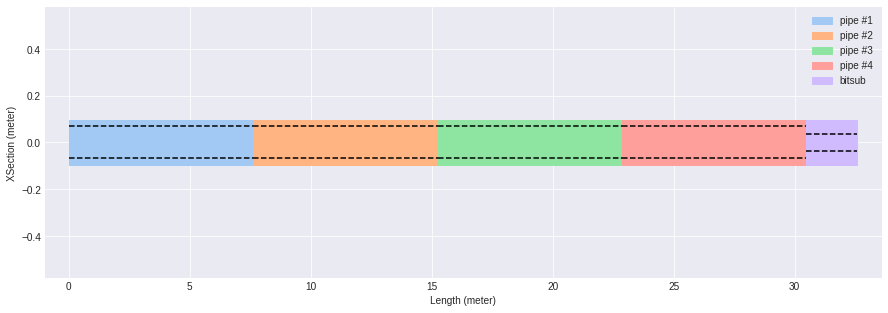

In [22]:
ds.plot()

In [175]:
ds['pipe #2']

<Drill component: pipe #2 - OD: 0.19 meter, ID: 0.14 meter, Length: 7.62 meter>

In [176]:
def get_component_interfaces(self, traveling_up=True):
    interfaces = {}
    for i, dc in enumerate(ds):
        if (i + 1) < len(ds.drill_components):
            interfaces[dc.name] = ds.drill_components[i + 1].name

In [177]:
interfaces

{'pipe #1': 'pipe #2', 'pipe #2': 'bitsub'}

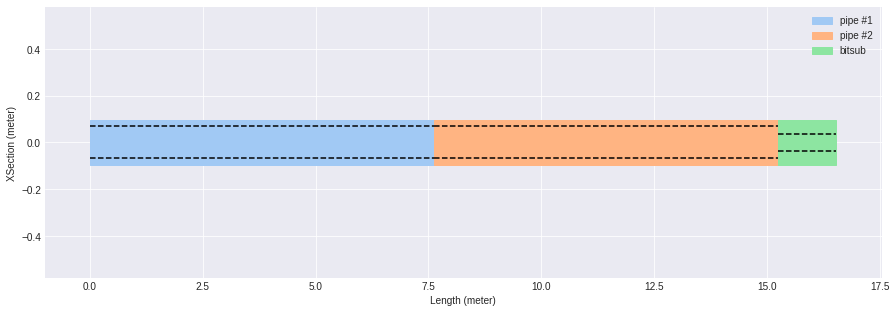

In [12]:
ds.plot()

In [91]:
class WaveTrajectory(object):
    def __init__(self, 
                 wave_type='primary',
                 initial_time=0, 
                 start_position=0, 
                 end_time=10, 
                 end_position=10, 
                 sensor_position=8,
                 velocity=1,
                 order=0,
                ):
        self.start_position = start_position
        self.initial_time = initial_time
        self.end_position = end_position
        self.velocity = velocity
        self.wave_type = wave_type
        self.sensor_position = sensor_position
        self.order = order
        
        self.traveling_up = (self.end_position < self.start_position)
        self.traveling_down = not(self.traveling_up)
        
        self.displacement = abs(self.end_position - self.start_position)
        
    def current_displacement(self, time):
        return self.velocity * time
    
    def current_position(self, time):
        displacement = self.current_displacement(time)
        return self.start_position - displacement if self.traveling_up else self.start_position + displacement
    
    @property
    def end_time(self):
        return self.displacement / self.velocity
    
    @property
    def displacement_to_sensor(self):
        if self.hit_sensor:
            return abs(self.sensor_position - self.start_position)
        else:
            return None        
    
    @property
    def displacement_after_sensor(self):
        if self.hit_sensor:
            return abs(self.sensor_position - self.end_position)
        else:
            return None        
    
    @property
    def hit_sensor(self):
        if self.traveling_up:
            if self.end_position <= self.sensor_position:
                return True
            else:
                return False
        if self.traveling_down:
            if self.end_position >= self.sensor_position:
                return True
            else:
                return False
        
    @property
    def time_it_hits_sensor(self):
        if self.hit_sensor:
            return self.velocity * self.displacement_to_sensor + self.initial_time
        else:
            return None

In [121]:
wt = WaveTrajectory(velocity=.5, initial_time=10, start_position=0, end_position=3, sensor_position=2.60)

In [124]:
wt.displacement_after_sensor

0.3999999999999999